## DATA FROM THE WEB

In [3]:
from bs4 import BeautifulSoup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rq
import seaborn as sns
import re
sns.set_context('notebook')

# 02 - Data from the Web

## Deadline
Monday October 17, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate 
unnecessary Web traffic during the peer review :)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework we will extract interesting information from [IS-Academia](http://is-academia.epfl.ch/page-6228.html), the educational
portal of EPFL. Specifically, we will focus on the part that allows [public access to academic data](http://is-academia.epfl.ch/publicaccess-Bachelor-Master).
The list of registered students by section and semester is not offered as a downloadable dataset, so you will have to find a way to scrape the
information we need. On [this form](http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247) you can select
the data to download based on different criteria (e.g., year, semester, etc.)

You are not allowed to download manually all the tables -- rather you have to understand what parameters the server accepts, and
generate accordingly the HTTP requests. For this task, [Postman](https://www.getpostman.com) with the [Interceptor extension](https://www.getpostman.com/docs/capture)
can help you greatly. I recommend you to watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1)
to understand quickly how to use it.
Your code in the iPython Notebook should not contain any hardcoded URL. To fetch the content from the IS-Academia server,
you can use the [Requests](http://docs.python-requests.org/en/master/) library with a Base URL, but all the other form parameters
should be extracted from the HTML with [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/).
You can choose to download Excel or HTML files -- they both have pros and cons, as you will find out after a quick check. You can also
choose to download data at different granularities (e.g., per semester, per year, etc.) but I recommend you not to download all the data
in one shot because 1) the requests are likely to timeout and 2) we will overload the IS-Academia server.

## Assignment
We will focus exclusively on the academic unit `Informatique`. When asked, select the right [statistical test](http://hamelg.blogspot.ch/2015/11/python-for-data-analysis-part-24.html).

1. Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both `Bachelor
semestre 1` and `Bachelor semestre 6`. Compute how many months it took each student to go from the first to the sixth semester. Partition
the data between male and female students, and compute the average -- is the difference in average statistically significant?

2. Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are
many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking
the distance in months between `Master semestre 1` and `Master semestre 2`. If the `Mineur` field is *not* empty, the student should also
appear registered in `Master semestre 3`. Last but not the least, don't forget to check if the student has an entry also in the `Projet Master`
tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a 
`Spécialisation` and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any
specialization for which the difference in average is statistically significant?

3. *BONUS*: perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes
over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

## GET THE GOOD TEST (EXPLAIN)

## Function getParamsRequestValue

The aim of this function is to return the parameter list that we will supply to query the server, in order to get
the list of students for a specific section, year and semester.

We have to do two requests. The first request loads the page with the form.
From there we can fetch the different values associated with the requested field (we looked at the HTML page to know what value we are looking for, such as 'ww_x_UNITE_ACAD'). From there, we generate a second request to fetch the 'ww_x_GPS' attribute's value generated by the previous request. It then sends back the map with the parameters.

For instance, a call like `getParamsRequestValue(133685247, 133685270, 'Informatique', '2007-2008', 'Bachelor semestre 1')` gives back:

```
{'dummy': 'ok',
 'ww_b_list': 1,
 'ww_i_reportModelXsl': 133685270,
 'ww_i_reportmodel': 133685247,
 'ww_x_GPS': 71297531,
 'ww_x_HIVERETE': 'null',
 'ww_x_PERIODE_ACAD': '978181',
 'ww_x_PERIODE_PEDAGO': '249108',
 'ww_x_UNITE_ACAD': '249847'}
 ```

In [4]:
def getParamsRequestValue(i_reportmodel_num, i_reportmodel_xsl_num, section, year, semester): 
    r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter', params={'ww_i_reportmodel' : i_reportmodel_num})
    parameters_map = { 'ww_x_UNITE_ACAD' : section, 'ww_x_PERIODE_ACAD' : year, 'ww_x_PERIODE_PEDAGO' : semester }
    
    soup = BeautifulSoup(r.text, 'html.parser')
    
    ps = {key: next((option.attrs['value'] for option in soup.find('select', {'name': key }) if option.text==value), None) for key, value in parameters_map.items()}
    o = {'ww_i_reportmodel' : i_reportmodel_num, 'ww_b_list' : 1, 'ww_i_reportModelXsl' : i_reportmodel_xsl_num, 'ww_x_HIVERETE' : 'null', 'dummy' : 'ok'}
    d = {**o, **ps}
    r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter', params=d)
    soup = BeautifulSoup(r.text, 'html.parser')
    for p in soup.find_all('a'):
        if(p.text==', '.join([section, year, semester])):
            arr = re.search('\(\'(.+?)\'\)', p['onclick']).group(1).split("=")
            d[arr[0]] = int(arr[1])
                  
    return d
#getParamsRequestValue(133685247, 133685270, 'Informatique', '2007-2008', 'Bachelor semestre 1')

### Initialize the value of reportmodel and Section, years and semesters we want.

In [5]:
ww_i_reportmodel_num=133685247
ww_i_reportModelXsl_num=133685270
section = 'Informatique'
bachelor_semesters = ['Bachelor semestre 1', 'Bachelor semestre 2', 'Bachelor semestre 3', 'Bachelor semestre 4', 'Bachelor semestre 5', 'Bachelor semestre 6']
years_semesters = {'2007-2008': ['Bachelor semestre 1', 'Bachelor semestre 2'], 
                   '2008-2009': ['Bachelor semestre 1', 'Bachelor semestre 2', 'Bachelor semestre 3', 'Bachelor semestre 4'] , 
                   '2009-2010': bachelor_semesters, 
                   '2010-2011': bachelor_semesters, 
                   '2011-2012': bachelor_semesters, 
                   '2012-2013': bachelor_semesters, 
                   '2013-2014': bachelor_semesters,
                   '2014-2015': bachelor_semesters, 
                   '2015-2016': ['Bachelor semestre 5', 'Bachelor semestre 6'], 
                   '2016-2017': ['Bachelor semestre 5', 'Bachelor semestre 6'] }

### Get columns' name

In [6]:
year='2007-2008'
semester='Bachelor semestre 1'
payload = getParamsRequestValue(ww_i_reportmodel_num, ww_i_reportModelXsl_num, section, year, semester)
r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?', params=payload)
soup = BeautifulSoup(r.text, 'html.parser')
list_attr = []
attributs = soup.find_all('th')
for attr in attributs:
    if(attr.string!=None):
        list_attr.append(attr.string)

list_attr.append("")
print(list_attr)

['Civilité', 'Nom Prénom', 'Orientation Bachelor', 'Orientation Master', 'Spécialisation', 'Filière opt.', 'Mineur', 'Statut', 'Type Echange', 'Ecole Echange', 'No Sciper', '']


### Go through the years/semesters and get the data

In [7]:
df_all = pd.DataFrame(columns=list_attr)
for year,semesters in years_semesters.items():
    for semester in semesters:
        payload = getParamsRequestValue(ww_i_reportmodel_num, ww_i_reportModelXsl_num, section, year, semester)
        r = rq.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?', params=payload)
        soup = BeautifulSoup(r.text, 'html.parser')
        tds = soup.find_all('td')
        df = pd.DataFrame(columns=list_attr)
        pers = pd.Series()
        i=0
        j=0
        for elem in tds:
            pers.set_value(list_attr[(i%len(list_attr))], elem.string)
            i+=1
            if(i%len(list_attr)==0):
                j+=1
                df.loc[j]=pers
                pers.iloc[1:]

# We delete the empty column (and others if needed)
        del df[""]
        print(semester)
        df["Bachelor Semestre"]=re.findall(r'\d',semester)[0]
        df["Year"]=year
        df_all = df_all.append(df, ignore_index=True)


Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 3
Bachelor semestre 4
Bachelor semestre 5
Bachelor semestre 6
Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 3
Bachelor semestre 4
Bachelor semestre 5
Bachelor semestre 6
Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 3
Bachelor semestre 4
Bachelor semestre 5
Bachelor semestre 6
Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 3
Bachelor semestre 4
Bachelor semestre 5
Bachelor semestre 6
Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 3
Bachelor semestre 4
Bachelor semestre 5
Bachelor semestre 6
Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 3
Bachelor semestre 4
Bachelor semestre 5
Bachelor semestre 6
Bachelor semestre 5
Bachelor semestre 6
Bachelor semestre 1
Bachelor semestre 2
Bachelor semestre 3
Bachelor semestre 4
Bachelor semestre 5
Bachelor semestre 6


### Store table in a csv to avoid asking IS-Academia everytime we restart our script

In [8]:
df_all.to_csv('student_bachelor.csv', sep=';', encoding='utf-8')


# Question 1
Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both Bachelor
semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

### Import csv file created before

We delete two columns we don't need

In [9]:
data = pd.read_csv('student_bachelor.csv', sep=';')


In [10]:
data=data.drop('Unnamed: 0', axis=1)
data=data.drop('Unnamed: 1', axis=1)

### Filter

Filter the students to keep only one entry per student with the number of semester done and the order.

In [11]:
students_bachelor=data[['No Sciper','Civilité', 'Nom Prénom', 'Bachelor Semestre', 'Year']]
students_bachelor.set_index('No Sciper')
students_bachelor.head()
unique_sciper=pd.unique(students_bachelor['No Sciper'])
unique_sciper_df=pd.DataFrame(unique_sciper, columns=['No Sciper'])

k=0
semesters=[]
nb_semesters=[]
years=[]
civilites=[]

students_bachelor=students_bachelor.sort_values(by=['Year','Bachelor Semestre'])

for i in range(0,len(unique_sciper_df)):
    student=students_bachelor[students_bachelor['No Sciper']==unique_sciper_df['No Sciper'][i]]
    semester=[]
    year=[]
    civilites.append(student['Civilité'].values[0])
    nb_semester=0
    for student_semester in student['Bachelor Semestre']:
        semester.append(student_semester)
        nb_semester+=1
    for student_year in student['Year']:
        year.append(student_year)
    semesters.append(semester)
    years.append(year)
    nb_semesters.append(nb_semester)
unique_sciper_df['Semestres']=semesters
unique_sciper_df['Nb semestres']=nb_semesters
unique_sciper_df['Année']=years
unique_sciper_df['Civilité']=civilites
unique_sciper_df  

,No Sciper,Semestres,Nb semestres,Année,Civilité
0,169569,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
1,174905,"[1, 2, 3, 4, 3, 4, 5, 6, 5, 6]",10,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
2,173922,"[1, 2, 3, 4, 5]",5,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
3,179406,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
4,179428,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
5,179324,"[1, 2]",2,"[2007-2008, 2007-2008]",Monsieur
6,174597,[1],1,[2007-2008],Monsieur
7,179449,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
8,178553,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
9,179426,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur


#### Now we have the order in which the students did their semesters

Let's test if they did their 6th semester

In [12]:
students_with_bachelor=unique_sciper_df
to_del=[]

for i in range(0, len(unique_sciper_df)):
    if 6 not in unique_sciper_df['Semestres'][i]:
        to_del+=[i]


students_with_bachelor=students_with_bachelor.drop(students_with_bachelor.index[to_del])
    
students_with_bachelor

,No Sciper,Semestres,Nb semestres,Année,Civilité
0,169569,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
1,174905,"[1, 2, 3, 4, 3, 4, 5, 6, 5, 6]",10,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
3,179406,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
4,179428,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
7,179449,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
8,178553,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
9,179426,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
10,178271,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
12,180731,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
13,171619,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur


#### We see that some students have less than 6 semesters (meaning they didn't do their study only at EPFL), we have to discard them

In [13]:
students_with_bachelor_at_EPFL=students_with_bachelor[students_with_bachelor['Nb semestres']>=6]
students_with_bachelor_at_EPFL

,No Sciper,Semestres,Nb semestres,Année,Civilité
0,169569,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
1,174905,"[1, 2, 3, 4, 3, 4, 5, 6, 5, 6]",10,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
3,179406,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
4,179428,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
7,179449,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
8,178553,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
9,179426,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
10,178271,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
12,180731,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur
13,171619,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur


#### We now reindex the dataframe

In [14]:
students_with_bachelor_at_EPFL = students_with_bachelor_at_EPFL.reset_index(drop=True)

### Cases of students finishing in Bachelor 5

This case happens when students need to redo a semester
In this case we do the assumption that if they did their 6th semester and redo a 5th semester after it, they did get their bachelor. The only case we have to care about is the students that are currently (2016-2017) re-doing their 5th semester and as we don't know if they will redo their 6th semester too we cannot count them as having their bachelor.

In [15]:
to_del=[]
for i in range(0, len(students_with_bachelor_at_EPFL)):
    if((students_with_bachelor_at_EPFL['Semestres'][i][-1]==5) & (students_with_bachelor_at_EPFL['Année'][i][-1]=="2016-2017")):
        to_del+=[i]
        
students_with_bachelor_at_EPFL=students_with_bachelor_at_EPFL.drop(students_with_bachelor_at_EPFL.index[to_del])

### Compute the number of months needed

Now that we have our needed data, we want to compute the number of month they needed to get their bachelor. (= 6 times the number of semester).
We here assume that one semester contains 6 months.

In [16]:
students_with_bachelor_at_EPFL['Nb mois']=6 * students_with_bachelor_at_EPFL['Nb semestres']
students_with_bachelor_at_EPFL

,No Sciper,Semestres,Nb semestres,Année,Civilité,Nb mois
0,169569,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,36
1,174905,"[1, 2, 3, 4, 3, 4, 5, 6, 5, 6]",10,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,60
2,179406,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,48
3,179428,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,48
4,179449,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,36
5,178553,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,36
6,179426,"[1, 2, 3, 4, 5, 6, 5, 6]",8,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,48
7,178271,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,36
8,180731,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,36
9,171619,"[1, 2, 3, 4, 5, 6]",6,"[2007-2008, 2007-2008, 2008-2009, 2008-2009, 2...",Monsieur,36


### Male/Female Partitioning
We first split our DataFrame into male and female students before computing the requested statistics.

In [17]:
male_students = students_with_bachelor_at_EPFL[students_with_bachelor_at_EPFL['Civilité'] == 'Monsieur']
female_students = students_with_bachelor_at_EPFL[students_with_bachelor_at_EPFL['Civilité'] == 'Madame']

female_students.shape

(25, 6)

We now compute the average of needed months to obtain the bachelor in each of our previously obtained frames. 

In [18]:
male_avg = male_students['Nb mois'].mean()
female_avg = female_students['Nb mois'].mean()
print('Male Average: ' + str(male_avg) +  '\nFemale Average: ' + str(female_avg))




Male Average: 42.25454545454546
Female Average: 38.88


We here have a first idea of the statisticcal difference between the two categories. We go a bit deeper in order to have an idea about the statistic distribution of each one of them. 

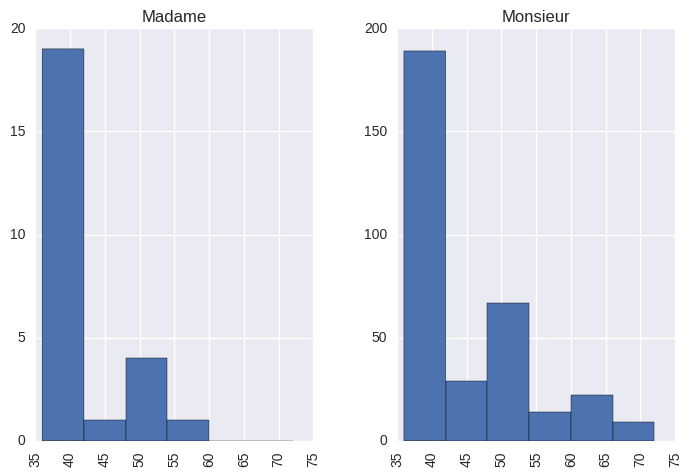

In [21]:
students_with_bachelor_at_EPFL['Nb mois'].hist(by=students_with_bachelor_at_EPFL['Civilité'], bins = 6, range = [36,72])
#students_with_bachelor_at_EPFL['Nb semestres'].hist(by=students_with_bachelor_at_EPFL['Civilité'])

plt.show()

We can see that male students statistically take in average more months to finish their bachelor than female students. A high majority of students (male and female) finish their bachelor in 36 months (3years). We only have 5 female students (20%) taking more than 36 months to finish it. 
Since our female students sample is very low in size (25 students), we cannot conclude powerf